# Install Necessary Library

In [1]:
!pip install tensorflow==2.10
!pip install deepctr[cpu]
!wget -c https://labs.criteo.com/wp-content/uploads/2015/04/dac_sample.tar.gz -O - | tar -xz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 42.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.2/141.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 18.4 MB/s eta 0:00:00
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.10.0 which is incompatible.
--2024-05-12 07:01:43--  https://labs.criteo.com/wp-content/uploads/2015/04/dac_sample.tar.gz
Resolving labs.criteo.com (labs.criteo.com)... 87.98.154.146
Connecting to labs.criteo.com (labs.criteo.com)|87.98.154.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8787154 (8.4M) [application/x-gzip]
Saving to: ‘STDOUT’

-                     2%[                    ] 202.95K   343KB/s     

# Import Library

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import log_loss, roc_auc_score


from itertools import chain

import tensorflow as tf
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, Concatenate ,Flatten ,Lambda

from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names
from deepctr.feature_column import build_input_features, get_linear_logit, DEFAULT_GROUP_NAME, input_from_feature_columns
from deepctr.layers.core import PredictionLayer, DNN
from deepctr.layers.interaction import FM ,InteractingLayer
from deepctr.layers.utils import concat_func, add_func, combined_dnn_input

from deepctr.feature_column import build_input_features, get_linear_logit, input_from_feature_columns ,VarLenSparseFeat

from deepctr.layers.core import PredictionLayer, DNN ,RegulationModule
from deepctr.layers.interaction import CrossNet ,BridgeModule
from deepctr.layers.utils import add_func, combined_dnn_input
from deepctr.models import EDCN




In [4]:
columns = ['label', *(f'I{i}' for i in range(1, 14)), *(f'C{i}' for i in range(1, 27))]
data = pd.read_csv('dac_sample.txt', sep='\t', names=columns).fillna('-1')
data.head()

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,-1,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,-1,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,...,8efede7f,3412118d,-1,-1,e587c466,ad3062eb,3a171ecb,3b183c5c,-1,-1
3,0,-1,893,-1,-1,4392.0,-1,0.0,0.0,0.0,...,1e88c74f,74ef3502,-1,-1,6b3a5ca6,-1,3a171ecb,9117a34a,-1,-1
4,0,3.0,-1,-1,0.0,2.0,0.0,3.0,0.0,0.0,...,1e88c74f,26b3c7a7,-1,-1,21c9516a,-1,32c7478e,b34f3128,-1,-1


In [5]:
sparse_features = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I' + str(i) for i in range(1, 14)]

data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0, )
target = ['label']

for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])


fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].max() + 1, embedding_dim=4)
                          for i, feat in enumerate(sparse_features)] + [DenseFeat(feat, 1, )
                                                                        for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)


train, test = train_test_split(data, test_size=0.2, random_state=2020)
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}


# Defion Models



## Deep And Cross Network

In [6]:
def DCN(linear_feature_columns, dnn_feature_columns, cross_num=2, cross_parameterization='vector',
        dnn_hidden_units=(256, 128, 64), l2_reg_linear=1e-5, l2_reg_embedding=1e-5,
        l2_reg_cross=1e-5, l2_reg_dnn=0, seed=1024, dnn_dropout=0, dnn_use_bn=False,
        dnn_activation='relu', task='binary'):

    if len(dnn_hidden_units) == 0 and cross_num == 0:
        raise ValueError("Either hidden_layer or cross layer must > 0")

    features = build_input_features(dnn_feature_columns)
    inputs_list = list(features.values())

    linear_logit = get_linear_logit(features, linear_feature_columns, seed=seed, prefix='linear',
                                    l2_reg=l2_reg_linear)

    sparse_embedding_list, dense_value_list = input_from_feature_columns(features, dnn_feature_columns,
                                                                         l2_reg_embedding, seed)

    dnn_input = combined_dnn_input(sparse_embedding_list, dense_value_list)

    if len(dnn_hidden_units) > 0 and cross_num > 0:  # Deep & Cross
        deep_out = DNN(dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed)(dnn_input)
        cross_out = CrossNet(cross_num, parameterization=cross_parameterization, l2_reg=l2_reg_cross)(dnn_input)
        stack_out = Concatenate()([cross_out, deep_out])
        final_logit = Dense(1, use_bias=False)(stack_out)
    elif len(dnn_hidden_units) > 0:  # Only Deep
        deep_out = DNN(dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed)(dnn_input)
        final_logit = Dense(1, use_bias=False)(deep_out)
    elif cross_num > 0:  # Only Cross
        cross_out = CrossNet(cross_num, parameterization=cross_parameterization, l2_reg=l2_reg_cross)(dnn_input)
        final_logit = Dense(1, use_bias=False)(cross_out)
    else:  # Error
        raise NotImplementedError

    final_logit = add_func([final_logit, linear_logit])
    output = PredictionLayer(task)(final_logit)

    model = Model(inputs=inputs_list, outputs=output)

    return model

In [7]:
model = DCN(linear_feature_columns, dnn_feature_columns, task='binary')
model.compile("adam", "binary_crossentropy",
              metrics=['accuracy'], )

history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
pred_ans = model.predict(test_model_input, batch_size=256)
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

CrossNet parameterization: vector
Epoch 1/10
250/250 - 21s - loss: 0.4823 - accuracy: 0.7848 - val_loss: 0.4552 - val_accuracy: 0.7949
Epoch 2/10
250/250 - 8s - loss: 0.3212 - accuracy: 0.8724 - val_loss: 0.5140 - val_accuracy: 0.7642
Epoch 3/10
250/250 - 6s - loss: 0.2220 - accuracy: 0.9107 - val_loss: 0.5928 - val_accuracy: 0.7538
Epoch 4/10
250/250 - 8s - loss: 0.1702 - accuracy: 0.9287 - val_loss: 0.7494 - val_accuracy: 0.7153
Epoch 5/10
250/250 - 6s - loss: 0.1421 - accuracy: 0.9400 - val_loss: 0.8891 - val_accuracy: 0.7139
Epoch 6/10
250/250 - 8s - loss: 0.1225 - accuracy: 0.9478 - val_loss: 1.0002 - val_accuracy: 0.7200
Epoch 7/10
250/250 - 6s - loss: 0.1067 - accuracy: 0.9547 - val_loss: 1.1648 - val_accuracy: 0.7494
Epoch 8/10
250/250 - 8s - loss: 0.0941 - accuracy: 0.9610 - val_loss: 1.2850 - val_accuracy: 0.7425
Epoch 9/10
250/250 - 6s - loss: 0.0823 - accuracy: 0.9664 - val_loss: 1.4635 - val_accuracy: 0.7403
Epoch 10/10
250/250 - 7s - loss: 0.0738 - accuracy: 0.9708 - val_

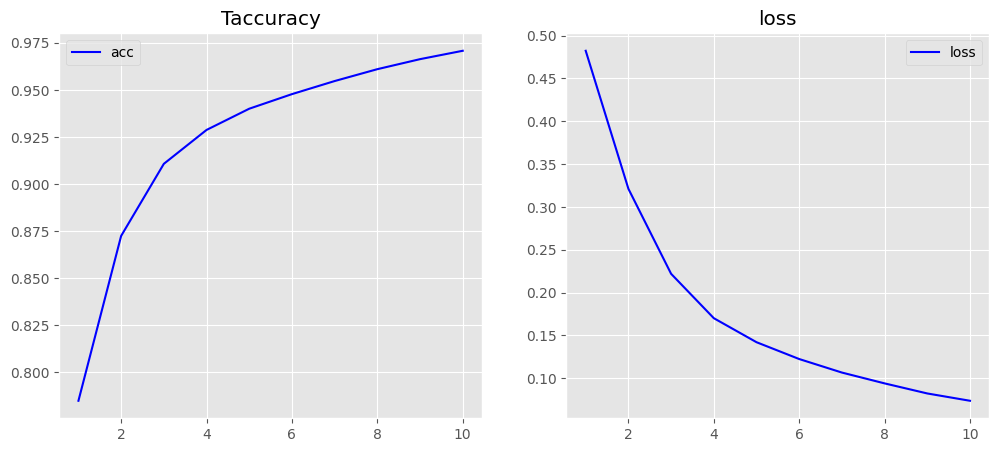

In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='acc')
    plt.title('Taccuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='loss')
    plt.title('loss')
    plt.legend()
plot_history(history)

## Dual Input Factorization Machine

In [11]:
def DIFM(linear_feature_columns, dnn_feature_columns,
         att_embedding_size=8, att_head_num=8, att_res=True, dnn_hidden_units=(256, 128, 64),
         l2_reg_linear=0.00001, l2_reg_embedding=0.00001, l2_reg_dnn=0, seed=1024, dnn_dropout=0,
         dnn_activation='relu', dnn_use_bn=False, task='binary'):


    if not len(dnn_hidden_units) > 0:
        raise ValueError("dnn_hidden_units is null!")

    features = build_input_features(
        linear_feature_columns + dnn_feature_columns)

    sparse_feat_num = len(list(filter(lambda x: isinstance(x, SparseFeat) or isinstance(x, VarLenSparseFeat),
                                      dnn_feature_columns)))
    inputs_list = list(features.values())

    sparse_embedding_list, _ = input_from_feature_columns(features, dnn_feature_columns,
                                                          l2_reg_embedding, seed)

    if not len(sparse_embedding_list) > 0:
        raise ValueError("there are no sparse features")

    att_input = concat_func(sparse_embedding_list, axis=1)
    att_out = InteractingLayer(att_embedding_size, att_head_num, att_res, scaling=True)(att_input)
    att_out = Flatten()(att_out)
    m_vec = Dense(sparse_feat_num, use_bias=False)(att_out)

    dnn_input = combined_dnn_input(sparse_embedding_list, [])
    dnn_output = DNN(dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed)(dnn_input)
    m_bit = Dense(sparse_feat_num, use_bias=False)(dnn_output)

    input_aware_factor = add_func([m_vec, m_bit])  # the complete input-aware factor m_x

    linear_logit = get_linear_logit(features, linear_feature_columns, seed=seed, prefix='linear',
                                    l2_reg=l2_reg_linear, sparse_feat_refine_weight=input_aware_factor)

    fm_input = concat_func(sparse_embedding_list, axis=1)
    refined_fm_input = Lambda(lambda x: x[0] * tf.expand_dims(x[1], axis=-1))(
        [fm_input, input_aware_factor])
    fm_logit = FM()(refined_fm_input)

    final_logit = add_func([linear_logit, fm_logit])

    output = PredictionLayer(task)(final_logit)
    model = Model(inputs=inputs_list, outputs=output)
    return model

In [12]:
model = DIFM(linear_feature_columns, dnn_feature_columns, task='binary')
model.compile("adam", "binary_crossentropy",
              metrics=['accuracy'], )

history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
pred_ans = model.predict(test_model_input, batch_size=256)
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

Epoch 1/10
250/250 - 24s - loss: 0.5036 - accuracy: 0.7653 - val_loss: 0.4659 - val_accuracy: 0.7911
Epoch 2/10
250/250 - 17s - loss: 0.3364 - accuracy: 0.8621 - val_loss: 0.5164 - val_accuracy: 0.7781
Epoch 3/10
250/250 - 17s - loss: 0.1720 - accuracy: 0.9307 - val_loss: 0.7583 - val_accuracy: 0.7374
Epoch 4/10
250/250 - 19s - loss: 0.1112 - accuracy: 0.9555 - val_loss: 0.9204 - val_accuracy: 0.7343
Epoch 5/10
250/250 - 24s - loss: 0.0821 - accuracy: 0.9679 - val_loss: 1.0699 - val_accuracy: 0.7301
Epoch 6/10
250/250 - 30s - loss: 0.0664 - accuracy: 0.9739 - val_loss: 1.4447 - val_accuracy: 0.7150
Epoch 7/10
250/250 - 17s - loss: 0.0564 - accuracy: 0.9781 - val_loss: 1.4602 - val_accuracy: 0.7144
Epoch 8/10
250/250 - 26s - loss: 0.0488 - accuracy: 0.9815 - val_loss: 1.4799 - val_accuracy: 0.7139
Epoch 9/10
250/250 - 32s - loss: 0.0435 - accuracy: 0.9837 - val_loss: 1.4018 - val_accuracy: 0.7195
Epoch 10/10
250/250 - 27s - loss: 0.0381 - accuracy: 0.9855 - val_loss: 1.7130 - val_accura

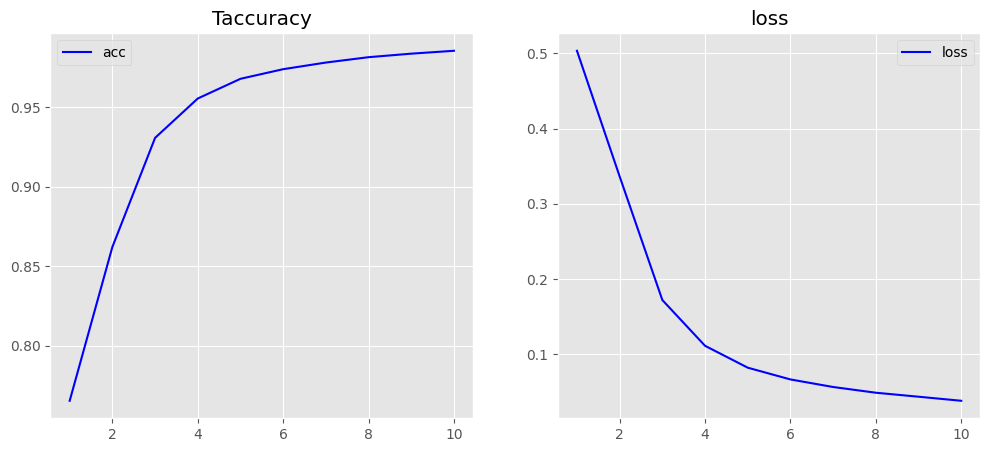

In [13]:
plot_history(history)